# In this notebook we will attempt to run Bayesian Regression on the full NBA dataset for 2018/19 season using priors from player contracts.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,6,...,519,520,521,522,523,524,525,526,527,528
0,-0.364583,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.390625,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.723380,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.361690,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.382966,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
priors_df = pd.read_csv("../data/priors_contract_only.csv")
priors_df.drop(priors_df.columns[0], axis = 1, inplace = True)
priors_df.head()


,mu,sd
0,0.000000,5
1,2.233600,5
2,1.723320,5
3,1.016797,5
4,4.785917,5


In [3]:
prior_means = np.array(priors_df.mu)
prior_sd = np.array(priors_df.sd)

In [4]:
# store home and away teams for potential use later when we incorporate team ratings
home_teams = data['home_team']
away_teams = data['away_team']
# now drop these columns from the main training dataframe
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,point_diff_per_100,0,1,2,3,4,5,6,7,8,...,519,520,521,522,523,524,525,526,527,528
0,-0.364583,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.390625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.723380,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.361690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.382966,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# need to rename columns now since numbers confuse pymc3
new_cols = []
for i in range(np.shape(data)[1]):
    if i == 0:
        new_cols.append("point_diff")
    else:
        new_cols.append("p" + str(i-1))

x_df = data.iloc[:10000,]
x_df.columns = new_cols
x_df

,point_diff,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p519,p520,p521,p522,p523,p524,p525,p526,p527,p528
0,-0.364583,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.390625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.723380,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.361690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.382966,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.175365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.234610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,-2.367424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bayesian Regression

Out of Bayesian regression, linear regression, and ridge regression it appears that Bayesian is giving the most sensible estimates, though these estimates are certainly not the most accurate at the moment. Note that we are only running this on the first 10,000 shifts out of about 33k shifts, so perhaps the increased data will help the models perform better. Of course it will also help to have some more informative priors. We can also mess around with the standard deviations of the priors since these are currently arbitrarily selected. Also having teams included in the priors should help guide the model.

Note - Steph Curry is index 317 and Lebron James is index 225, so for sanity checks we can check these players' coefficients compared to a random player. 

The highest coefficients are currently for random low profile players - my hypothesis is that the low sample size for these players is allowing their coefficients to rise more than they should, because if we also examine the standard deviations of these coefficients they are substantially higher than those for players like Lebron and Steph Curry. 

In [6]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]

with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd # defined above
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape)
    
    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y)

    trace = pm.sample(1000, tune = 1000, cores = 1)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 510 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
results_df = az.summary(trace)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [11]:
results_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.012,0.009,-0.004,0.029,0.000,0.000,4563.0,1552.0,1.00
x[0],2.018,0.133,1.790,2.290,0.035,0.026,15.0,25.0,1.07
x[1],2.109,0.136,1.874,2.378,0.036,0.026,15.0,23.0,1.06
x[2],2.000,0.134,1.771,2.267,0.035,0.025,15.0,17.0,1.06
x[3],2.105,0.135,1.873,2.370,0.035,0.025,15.0,23.0,1.06
...,...,...,...,...,...,...,...,...,...
x[525],-0.062,5.187,-9.034,10.108,0.066,0.167,6260.0,1007.0,1.01
x[526],2.814,0.625,1.652,3.925,0.019,0.015,1083.0,1523.0,1.00
x[527],2.136,0.260,1.643,2.617,0.035,0.025,56.0,403.0,1.02
x[528],0.085,4.982,-9.556,9.006,0.064,0.168,6092.0,855.0,1.01


In [39]:
with model:
#     print(results_df.loc['x[317]', 'mean'])
    print(results_df.loc[results_df['mean'] > 2.4])
    print(results_df.loc['x[167]', :])

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x[283]  3.427  0.599   2.323    4.547      0.021    0.015     818.0    1631.0   
x[304]  2.441  0.436   1.647    3.293      0.027    0.019     255.0    1207.0   
x[376]  2.508  0.736   1.182    3.893      0.017    0.013    1854.0    1093.0   
x[521]  2.723  0.801   1.216    4.206      0.018    0.013    1996.0    1221.0   
x[526]  2.814  0.625   1.652    3.925      0.019    0.015    1083.0    1523.0   

        r_hat  
x[283]    1.0  
x[304]    1.0  
x[376]    1.0  
x[521]    1.0  
x[526]    1.0  
mean          2.117
sd            0.136
hdi_3%        1.893
hdi_97%       2.396
mcse_mean     0.036
mcse_sd       0.026
ess_bulk     15.000
ess_tail     23.000
r_hat         1.060
Name: x[167], dtype: float64


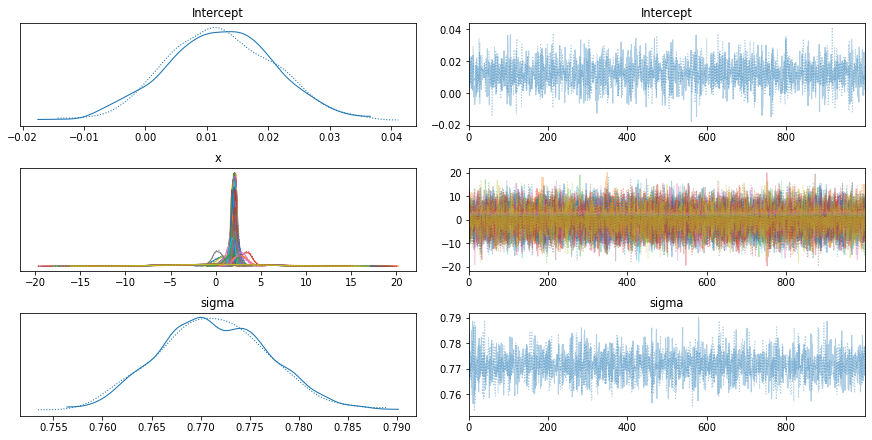

In [25]:
with model:
    az.plot_trace(trace)

## Next: Compare these results with ridge regression and standard linear regression

Note - these results are very weird. Seems like the coefficients are either blowing up or going to zero. Perhaps ridge will be better.

In [44]:
# Linear Reg first:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)

In [48]:
reg.score(x,y)
reg.coef_

array([ 8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  8.20094185e+11,  8.20094185e+11,  8.20094185e+11,
        8.20094185e+11,  

## Ridge Regression

These estimates seem slightly more reasonable but still not really valid. Perhaps the regularization parameter is not where it should be. 

In [49]:
from sklearn.linear_model import Ridge

ridge_model = Ridge().fit(x, y)

In [56]:
ridge_model.coef_

array([-6.12323439e-02,  3.05229036e-02, -8.08319510e-02,  2.78358385e-02,
        1.43371661e-01,  1.23323084e-01, -5.12968545e-02, -2.74137373e-02,
        3.89878236e-02, -1.76455800e-02,  1.04115413e-01, -2.13783840e-01,
        9.32719877e-03,  6.64036981e-02, -8.11600147e-02, -1.34482830e-01,
        9.79306622e-03,  1.18588846e-01,  1.41640254e-01, -1.05109679e-02,
        1.06144627e-02, -2.45865658e-01, -2.52870944e-02,  3.99060478e-02,
        1.15896151e-02, -8.61623633e-02,  1.72242693e-01, -1.04481968e-01,
        1.41731315e-01,  4.41796862e-02,  2.02008305e-03,  1.04741354e-01,
        9.96621665e-02, -1.33617600e-01, -1.86254897e-01, -1.10863362e-01,
       -4.25271392e-02,  3.91652824e-02,  1.07202206e-01,  9.07707923e-02,
        5.51710661e-02,  1.61063632e-01,  6.21800486e-02, -3.06679150e-02,
        1.73003694e-01,  3.25742456e-02,  4.88299588e-02, -7.20721863e-02,
        2.07093460e-02,  5.57059505e-02,  2.87120598e-02, -4.29593243e-02,
        1.37220850e-02,  